In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from matplotlib import style
style.use('dark_background')

In [27]:
# Open no1_train.csv and no1_validation.csv
df_train = pd.read_csv('no1_train.csv')
df_test = pd.read_csv('no1_validation.csv')


# Extract target columns
y_train = df_train['y']
y_test = df_test['y']

# Then remove them from the dataframes
df_train = df_train.drop(['y'], axis=1)
df_test = df_test.drop(['y'], axis=1)

In [28]:
df_train.head()

,start_time,hydro,micro,thermal,wind,river,total,sys_reg,flow
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4


In [29]:
df_test.head()

,start_time,hydro,micro,thermal,wind,river,total,sys_reg,flow
0,2021-03-01 03:30:00,1942.49,191.881,20.1,106.431,0.0,2266.102,0.0,-2252.9
1,2021-03-01 03:35:00,1942.49,191.881,20.1,106.431,0.0,2266.102,0.0,-2252.9
2,2021-03-01 03:40:00,1942.49,191.881,20.1,106.431,0.0,2266.102,0.0,-2252.9
3,2021-03-01 03:45:00,1942.49,191.881,20.1,106.431,0.0,2266.102,0.0,-2252.9
4,2021-03-01 03:50:00,1942.49,191.881,20.1,106.431,0.0,2266.102,0.0,-2252.9


In [30]:
# Convert timestamps in "start_time" to seconds
df_train['start_time'] = pd.to_datetime(df_train['start_time'])
# Convert datetime into seconds since epoch
df_train['start_time'] = df_train['start_time'].apply(lambda x: x.timestamp())

# Do the same to df_test
df_test['start_time'] = pd.to_datetime(df_test['start_time'])
df_test['start_time'] = df_test['start_time'].apply(lambda x: x.timestamp())



In [31]:
df_train.head()

,start_time,hydro,micro,thermal,wind,river,total,sys_reg,flow
0,1.547043e+09,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
1,1.547043e+09,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2,1.547044e+09,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
3,1.547044e+09,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
4,1.547044e+09,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4


## Exploratory Data Analysis

First let's look at the data and see if we notice any outliers that might not correlate well with the overall trend of the data

In [32]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
start_time,225088.0,1.580806e+09,1.949324e+07,1.547043e+09,1.563925e+09,1.580806e+09,1.597688e+09,1.614569e+09
hydro,225088.0,1.888334e+03,4.010003e+02,6.834380e+02,1.625029e+03,1.933916e+03,2.175595e+03,2.995524e+03
micro,225088.0,2.241898e+02,5.855985e+01,8.037100e+01,1.850170e+02,2.259380e+02,2.695580e+02,3.492710e+02
thermal,225088.0,2.180350e+01,3.579229e+00,0.000000e+00,2.210000e+01,2.210000e+01,2.410000e+01,2.570000e+01
wind,225088.0,5.570327e+01,4.705303e+01,0.000000e+00,1.570400e+01,4.184800e+01,8.872300e+01,1.760000e+02
river,225088.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
total,225088.0,2.190032e+03,4.440777e+02,8.497320e+02,1.916523e+03,2.248874e+03,2.497792e+03,3.351974e+03
sys_reg,225088.0,-8.284305e+00,4.374831e+01,-8.280000e+02,0.000000e+00,0.000000e+00,0.000000e+00,4.740000e+02
flow,225088.0,-1.999055e+03,1.311682e+03,-5.541200e+03,-2.996700e+03,-1.953700e+03,-9.069000e+02,7.234000e+02


Seeing as river has absolutely all values equal to 0, this is not a good feature to use. We therefore drop it because
it gives no additional information

In [33]:
df_train = df_train.drop(['river'], axis=1)
df_test = df_test.drop(['river'], axis=1)

Let's visualize the data in several plots to see if we instinctively can see anything that doesn't add up

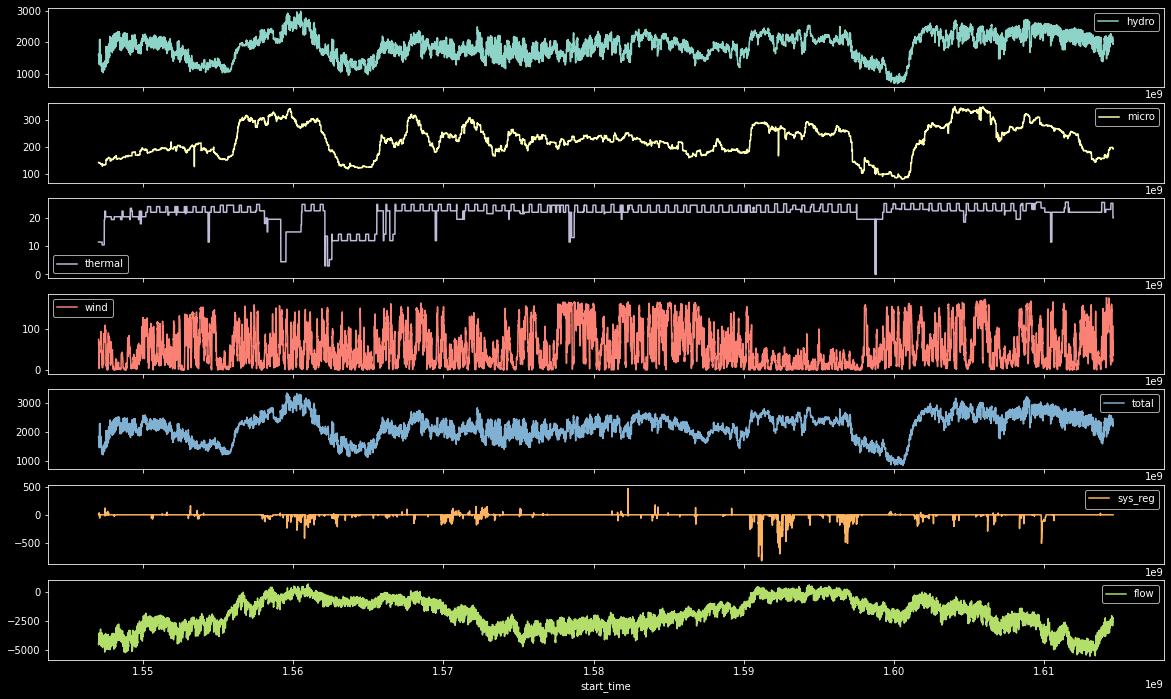

In [34]:
# Get column names from df_train except start_time
cols = df_train.columns.drop('start_time')
plot_features = df_train[cols]
plot_features.index = df_train['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

# plot_features = df_train[plot_cols][:480]
# plot_features.index = df_train["start_time"][:480]
# _ = plot_features.plot(subplots=True)

<AxesSubplot:>

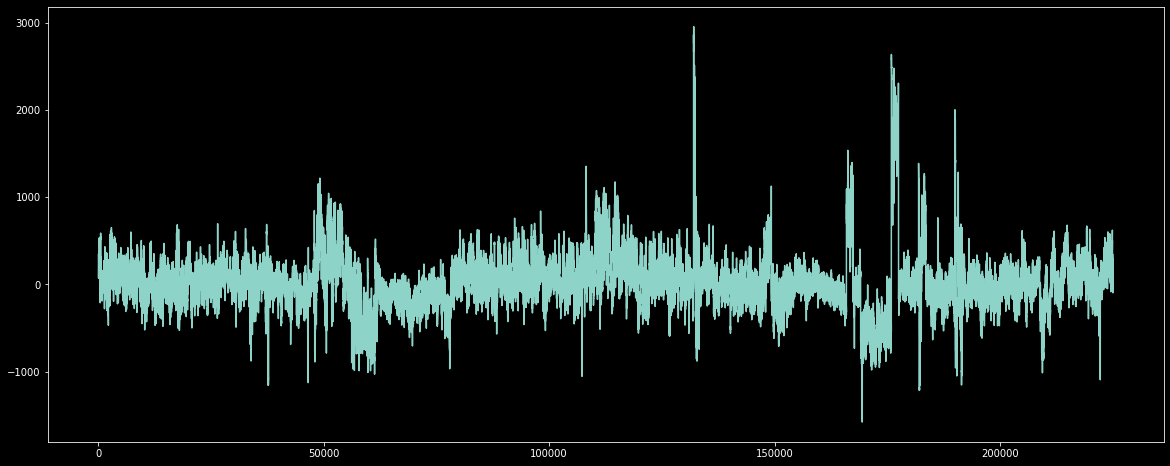

In [39]:
y_train.plot(figsize=(20, 8))

In [48]:
# Get index of y train where value is > 2900
y_train[y_train > 2900].index
# Display df_train with those indeces
df_train.loc[y_train[y_train > 2900].index]

,start_time,hydro,micro,thermal,wind,total,sys_reg,flow
132072,1.586665e+09,1507.904,170.925,24.6,90.787,1794.216,0.0,-1762.4
132073,1.586665e+09,1507.904,170.925,24.6,90.787,1794.216,0.0,-1762.4
132074,1.586665e+09,1507.904,170.925,24.6,90.787,1794.216,0.0,-1762.4


Let's see if there are any NaN-values present

In [20]:
# Check for NaN values
df_train.isnull().sum()

start_time    0
hydro         0
micro         0
thermal       0
wind          0
total         0
sys_reg       0
flow          0
Day sin       0
Day cos       0
Year sin      0
Year cos      0
dtype: int64

## Feature engineering
In this section, we will look at how we can manipulate the data in the dataset in order to better suit it for model prediction. This will include modifying existing features, and introducing new ones.

First we'll look at frequencies.
The nature of demand on the power grid is highly dependent on two key factors:
* The time of day
* The time of year

Seeing as the price of electricity has been a heated debate for the past half-year due to environmental and seasonal changes, this might be a good place to start.

In [16]:
day = 24*60*60
year = (365.2425)*day

df_train['Day sin'] = np.sin(df_train['start_time'] * (2 * np.pi / day))
df_train['Day cos'] = np.cos(df_train['start_time'] * (2 * np.pi / day))
df_train['Year sin'] = np.sin(df_train['start_time'] * (2 * np.pi / year))
df_train['Year cos'] = np.cos(df_train['start_time'] * (2 * np.pi / year))

In [17]:
df_train.head()

,start_time,hydro,micro,thermal,wind,total,sys_reg,flow,Day sin,Day cos,Year sin,Year cos
0,1.547043e+09,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-0.537300,-0.843391,0.149238,0.988801
1,1.547043e+09,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-0.555570,-0.831470,0.149297,0.988792
2,1.547044e+09,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-0.573576,-0.819152,0.149356,0.988783
3,1.547044e+09,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-0.591310,-0.806445,0.149416,0.988774
4,1.547044e+09,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-0.608761,-0.793353,0.149475,0.988766


In [18]:
train_mean = df_train.mean()
train_std = df_train.std()

norm_df_train = (df_train - train_mean) / train_std
norm_df_test = (df_test - train_mean) / train_std

In [19]:
norm_df_train.head(10)

,start_time,hydro,micro,thermal,wind,total,sys_reg,flow,Day sin,Day cos,Year sin,Year cos
0,-1.732039,-0.739389,-1.404748,-2.878692,0.39795,-0.833946,0.417943,-1.843697,-0.759435,-1.193107,0.163353,1.313273
1,-1.732024,-0.739389,-1.404748,-2.878692,0.39795,-0.833946,0.417943,-1.843697,-0.785274,-1.176247,0.163437,1.313260
2,-1.732008,-0.739389,-1.404748,-2.878692,0.39795,-0.833946,0.417943,-1.843697,-0.810739,-1.158828,0.163522,1.313248
3,-1.731993,-0.739389,-1.404748,-2.878692,0.39795,-0.833946,0.417943,-1.843697,-0.835817,-1.140857,0.163606,1.313235
4,-1.731978,-0.739389,-1.404748,-2.878692,0.39795,-0.833946,0.417943,-1.843697,-0.860498,-1.122343,0.163691,1.313223
5,-1.731962,-0.739389,-1.404748,-2.878692,0.39795,-0.833946,0.417943,-1.843697,-0.884769,-1.103295,0.163776,1.313210
6,-1.731947,-0.739389,-1.404748,-2.878692,0.39795,-0.833946,0.417943,-1.843697,-0.908618,-1.083723,0.163860,1.313197
7,-1.731932,-0.739389,-1.404748,-2.878692,0.39795,-0.833946,0.417943,-1.843697,-0.932035,-1.063634,0.163945,1.313185
8,-1.731916,-0.739389,-1.404748,-2.878692,0.39795,-0.833946,0.417943,-1.843697,-0.955008,-1.043040,0.164029,1.313172
9,-1.731901,-0.739389,-1.404748,-2.878692,0.39795,-0.833946,0.417943,-1.863153,-0.977526,-1.021949,0.164114,1.313160
